# Loading elevation data and clipping to countries of interest

In [1]:
import rioxarray
import xarray
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raster (your elevation dataset)
raster_path = r"../local_dataset/raw/elevation/be15_grd/be15_grd"   # or "be15_grd/hdr.adf"
dataset = rioxarray.open_rasterio(raster_path, masked=True)
# dataset = dataset.rio.write_crs("EPSG:4326")  # Ensure the CRS is set

# Load the shapefile (country boundaries)
shp_path = r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shp_path)

# Select only Algeria and Tunisia
countries = world[world["ADMIN"].isin(["Algeria", "Tunisia"])]

# Ensure same CRS
countries = countries.to_crs(dataset.rio.crs)

# Clip the raster using GeoDataFrame geometry
dataset = dataset.rio.clip(countries.geometry, countries.crs, from_disk=True)

# Inspect metadata and data
print("=== Metadata ===")
print(dataset.attrs)
print("=== Shape ===")
print(dataset.shape)
print("=== CRS ===")
print(dataset.rio.crs)

# # Plot the result
# plt.figure(figsize=(8, 6))
# dataset.plot(cmap='terrain', robust=True)
# plt.title("Elevation: Algeria & Tunisia")
# plt.show()


=== Metadata ===
{'scale_factor': 1.0, 'add_offset': 0.0}
=== Shape ===
(1, 4392, 4965)
=== CRS ===
EPSG:4326


In [2]:
all_cols = dataset.squeeze("band", drop=True).to_dataframe(name="elevation").reset_index()[["x", "y", "elevation"]].dropna(subset=["elevation"])
all_cols = all_cols.rename(columns={"x": "lon", "y": "lat"})
print(all_cols.shape)
print(all_cols.head())
elevation_col = all_cols["elevation"]


(13183993, 3)
           lon        lat  elevation
9331  9.506111  37.347778        0.0
9332  9.510278  37.347778        0.0
9333  9.514444  37.347778        0.0
9334  9.518611  37.347778        0.0
9335  9.522778  37.347778        0.0


# Univariate Analysis

In [3]:

print("Min:", elevation_col.min())
print("Max:", elevation_col.max())
print("Mean:", elevation_col.mean())
print("Standard Deviation:", elevation_col.std())
print("Median:", elevation_col.median())
print("Unique Values:", elevation_col.nunique())
print("Null Values:", elevation_col.isnull().sum())


Min: -872.0
Max: 2877.0
Mean: 536.3689652292746
Standard Deviation: 325.4793402116085
Median: 463.0
Unique Values: 2627
Null Values: 0


# Value Distribution and outliers

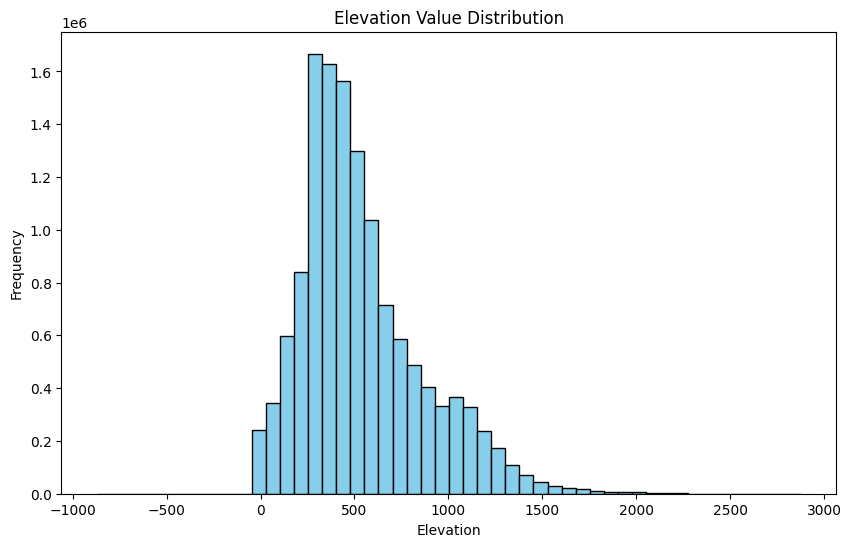

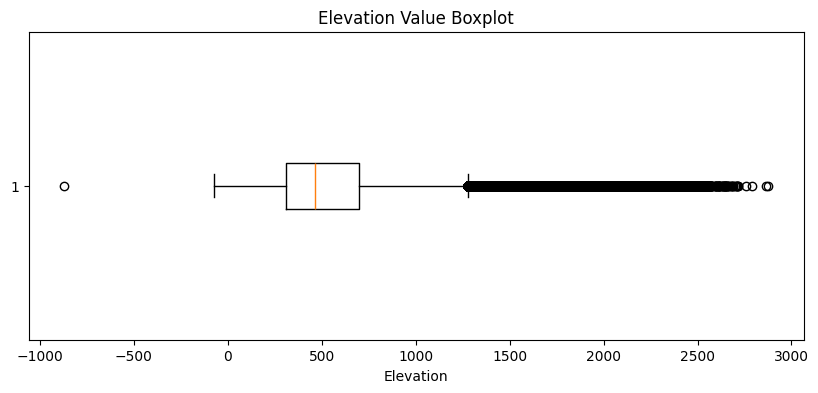

Number of outliers : 383253


In [15]:
def plot_histogram(col):
    plt.figure(figsize=(10, 6))
    plt.hist(col, bins=50, color='skyblue', edgecolor='black')
    plt.title("Elevation Value Distribution")
    plt.xlabel("Elevation")
    plt.ylabel("Frequency")
    plt.show()

def plot_box_plot(col):
    plt.figure(figsize=(10, 4))
    plt.boxplot(col, vert=False)
    plt.title("Elevation Value Boxplot")
    plt.xlabel("Elevation")
    plt.show()

plot_histogram(elevation_col)
plot_box_plot(elevation_col)

Q1 = elevation_col.quantile(0.25)
Q3 = elevation_col.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (elevation_col < (Q1 - 1.5 * IQR)) | (elevation_col > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum()
print(f"Number of outliers : {outlier_counts}")

# Correlation analysis

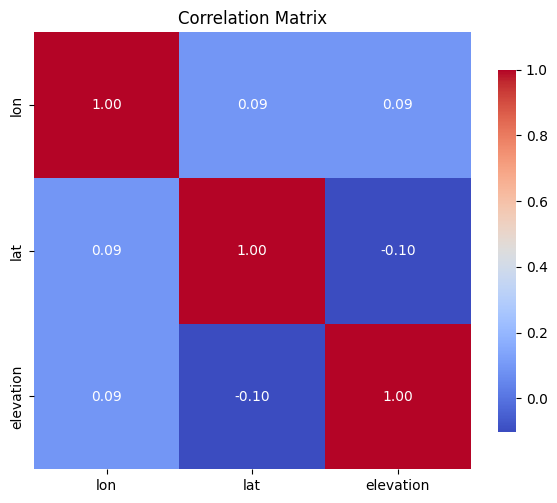

In [16]:
correlation_matrix = all_cols.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.tight_layout()  
plt.title("Correlation Matrix")
plt.show()

# Exporting the cleaned dataset

In [10]:
# xarray_dataset_full = xarray.Dataset.from_dataframe(all_cols)
# xarray_dataset_full.to_netcdf(r"../local_dataset/dataset/elevation_full.nc")
# print("NetCDF export complete.")

# dataset = xarray.open_dataset(r"../local_dataset/dataset/elevation_full.nc")
# dataset = dataset.to_dataframe().reset_index(drop=True)

# print(dataset.shape)

dataset.rio.to_raster(r"../local_dataset/dataset/elevation_full.tif", compress='LZW')

dataset = rioxarray.open_rasterio(r"../local_dataset/dataset/elevation_full.tif", masked=True)



CPLE_AppDefinedError: Deleting ../local_dataset/dataset/elevation_full.tif failed: Permission denied